In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.ticker
import matplotlib.pyplot as plt
import pickle
import datetime
import warnings
from scipy.stats import kendalltau
from itca import itca, GreedySearch, bidict, compute_y_dist
from sklearn.metrics import pairwise_distances, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from lifelines import CoxPHFitter
from aesthetics import params
mpl.rcParams.update(params)

In [3]:
#===================== Load data ============================
data_path = "../data/application2/gbm_tcga.csv"
gbm_df = pd.read_csv(data_path)
gbm_df.shape
gbm_df = gbm_df.drop(labels=['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type Detailed', 'Number of Samples Per Patient', 
                   'Oncotree Code', 'Somatic Status', 'Sample Type', 'Cancer Type'], axis=1)
Y = gbm_df[["Overall Survival (Months)", "Overall Survival Status"]]
gbm_df = gbm_df.drop(labels=["Overall Survival (Months)", "Overall Survival Status"], axis=1)
therapy = gbm_df["therapy"].str.get_dummies(",") # 10 columns
gbm_df = gbm_df.drop(labels=["therapy", "Mutation Count"], axis=1)
gbm_df_full = pd.concat([pd.get_dummies(gbm_df), therapy], axis=1)
gbm_df_full = gbm_df_full.fillna(gbm_df_full.mean()) # impute nan with column means 
Y = Y.replace({"1:DECEASED": 1, "0:LIVING":0})
isna = Y.isna().any(axis=1)
gbm_df_full = gbm_df_full[~isna]
Y = Y[~isna]
Y_arr = Y.to_numpy()
# Discretize survival month to 12 groups
Y_arr[:, 0] = np.minimum(np.floor(Y["Overall Survival (Months)"] / 3), 11)
Y_arr[Y_arr[:, 0] == 11, 1] = 1 # set the last group status to 1
X = gbm_df_full.to_numpy()

In [4]:
#============================ Neural network help functions ===================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, activation="relu"):
        super(Net, self).__init__()
        self.activation = "relu"
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for hdim in hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, output_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            if self.activation == "relu":
                x = F.relu(layer(x))
            elif self.activation == "sigmoid":
                x = F.sigmoid(layer(x))
            else:
                raise TypeError("Unknown activation function!")
        out = F.softmax(self.layers[-1](x), dim=1)
        return out

    
def censored_cross_entropy(output, target, p_dist):
    """
    My custom cross entropy for right censoring data.
    output: [n_samples, n_class], each row sums up to 1.
    target: [n_samples, 2],  the firt column indicates the the survaival group. 
    The second column indicates status of observation.
    """
    log_out = torch.log(output)
    loss1 = torch.sum(- log_out.gather(1, target[:, 0].long().view(-1, 1)) * target[:, 1].unsqueeze(1))
    # loss for censored data 
    mask = torch.zeros_like(output)
    p_dist_mat = p_dist.repeat(mask.shape[0], 1)
    for row_idx, y in enumerate(target[:, 0]):
        mask[torch.tensor(row_idx, dtype=torch.long), y.to(dtype=torch.long):] = 1
    mask_p_dist = p_dist_mat * mask
    weight = mask_p_dist / mask_p_dist.sum(dim=1).unsqueeze(1)
    loss2 = torch.sum(-log_out * weight * (1 - target[:, 1].unsqueeze(1)))
    return (loss1 + loss2) / output.shape[0]


def train_model(train_loader, net, optimizer, loss_function, test_data,
               n_epochs=300, verbose=False, p_dist=None):
    running_loss = []
    running_acc = []
    X_test, Y_test = test_data
    for epoch in range(n_epochs):
        for i, data in enumerate(train_loader):
            inputs, target = data
            optimizer.zero_grad()
            outputs = net(inputs)
            if p_dist is not None:
                loss = loss_function(outputs, target, p_dist)
            else:
                loss = loss_function(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
        pred = net(X_test)
        pred = np.argmax(pred.detach().numpy(), axis=1)
        acc = accuracy_score(Y_test[:, 0], pred)
        running_acc.append(acc)
        if verbose:
            print('epoch: %d loss: %.3f test acc: %.3f' % 
                    (epoch + 1, running_loss[-1], acc))
    return running_loss, running_acc


def cross_validation(width=30, layers=3, activation="relu"):
    batch_size=64
    n_epochs=150
    hidden_layers = [width for dummy_i in range(layers)]
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    acc_cv = []
    print("width: %d layers: %d activation %s" % (width, layers, activation))
    for train_index, test_index in skf.split(X, Y_arr[:, 0]):
        X_train, Y_train = X[train_index], Y_arr[train_index]
        X_test, Y_test = X[test_index], Y_arr[test_index]
        censored_idx = Y_test[:, 1] == 0
        X_train = np.concatenate([X_train, X_test[censored_idx]])
        Y_train = np.concatenate([
            Y_train, Y_test[censored_idx]])
        X_test = X_test[np.logical_not(censored_idx)]
        Y_test = Y_test[np.logical_not(censored_idx)]
        # construct dataloader
        train_data = TensorDataset(torch.tensor(X_train).float(), 
                                    torch.tensor(Y_train).long())
        net =  Net(36, 12, hidden_layers, activation=activation)
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,
                      weight_decay=0.01)
        _, running_acc = train_model(train_loader, net, optimizer, 
                                        censored_cross_entropy, 
                                        test_data, n_epochs=n_epochs, 
                                        verbose=False, p_dist=p_dist)
        acc_cv.append(running_acc[-1])
    return acc_cv

## The proposed loss function, CCE, outperforms CE singnificantly

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
n_epochs = 150
batch_size = 128
acc_cce = []
acc_ce = []
_, p_dist = np.unique(Y_arr[:, 0], return_counts=True)
p_dist = torch.from_numpy(p_dist / np.sum(p_dist))
for i in range(1):
    acc1, acc2 = [], []
    for train_index, test_index in skf.split(X, Y_arr[:, 0]):
        X_train, Y_train = X[train_index], Y_arr[train_index]
        X_test, Y_test = X[test_index], Y_arr[test_index]
        censored_idx = Y_test[:, 1] == 0
        X_train1 = np.concatenate([X_train, X_test[censored_idx]])
        Y_train1 = np.concatenate([Y_train, Y_test[censored_idx]])
        X_test = X_test[np.logical_not(censored_idx)]
        Y_test = Y_test[np.logical_not(censored_idx)]
        X_train2 = X_train1[Y_train1[:, 1] == 1]
        Y_train2 = Y_train1[Y_train1[:, 1] == 1]
        # construct dataloader
        train_data1 = TensorDataset(torch.tensor(X_train1).float(), 
                                    torch.tensor(Y_train1).long())
        train_data2 = TensorDataset(torch.tensor(X_train2).float(), 
                                    torch.tensor(Y_train2[:, 0]).long())
        test_data = (torch.tensor(X_test, dtype=torch.float), Y_test)
        train_loader1= DataLoader(train_data1, batch_size=batch_size)
        net1 = Net(36, 12, [40, 40, 40, 40])
        optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9,
                          weight_decay=0.01)
        _, running_acc1 = train_model(train_loader1, net1, optimizer1, 
                                            censored_cross_entropy, 
                                            test_data, n_epochs=n_epochs, 
                                            verbose=False, p_dist=p_dist)
        acc1.append(running_acc1[-1])
        train_loader2= DataLoader(train_data2, batch_size=batch_size)
        net2 = Net(36, 12, [40, 40, 40, 40])
        optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9,
                          weight_decay=0.01)
        _, running_acc2 = train_model(train_loader2, net2, optimizer2, 
                                            nn.CrossEntropyLoss(), 
                                            test_data, n_epochs=n_epochs, 
                                            verbose=False, p_dist=None)
        acc2.append(running_acc2[-1])
    acc_cce.append(acc1)
    acc_ce.append(acc2)
# The censored cross entropy outperforms the classical cross entropy loss significantly
print("Test Accuracy of Censored Cross-entropy: %.4f (%.4f)" \
      %(np.mean(acc1), np.std(acc1)))
print("Test Accuracy of Cross-entropy: %.4f (%.4f)"\
      %(np.mean(acc2), np.std(acc2)))

Test Accuracy of Censored Cross-entropy: 0.3186 (0.0315)
Test Accuracy of Cross-entropy: 0.1085 (0.0701)


In [23]:
# help functions for manipulate the combination mapping 
def combine_i_j(i, j, mapping):
    next_mapping = dict()
    for key in mapping.inverse:
        if key < j:
            next_mapping.update({e: key for e in mapping.inverse[key]})
        elif key > j:
            next_mapping.update({e: key - 1 for e in mapping.inverse[key]})
        else:
            next_mapping.update({e: i for e in mapping.inverse[key]})
    return bidict(next_mapping)

def next_mapping(mapping):
    for i in range(len(mapping.inverse) - 1):
        yield combine_i_j(i, i + 1, mapping)

def eval_model_cv(X_arr, Y_arr, mapping, nfolds=5,  n_epochs=150, 
                  batch_size=64, seed=None, layers=None, activation="relu",
                 opt_params={"lr": 0.001, "momentum": 0.9,
                          "weight_decay": 0.01}):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    Y_arr_ = np.copy(Y_arr)
    Y_arr_[:, 0] = mapping.map(Y_arr_[:, 0])
    n_classes = np.unique(Y_arr_[:, 0]).size
    y_dist = compute_y_dist(Y_arr[:, 0])
    _, p_dist_ = np.unique(Y_arr_[:, 0], return_counts=True)
    p_dist_ = torch.from_numpy(p_dist_ / np.sum(p_dist_))
    res = {"ACC": [], "ITCA": [], "tau": []}
    for train_index, test_index in skf.split(X, Y_arr_[:, 0]):
        X_train, Y_train = X[train_index], Y_arr_[train_index]
        X_test, Y_test = X[test_index], Y_arr_[test_index]
        censored_idx = Y_test[:, 1] == 0
        X_train = np.concatenate([X_train, X_test[censored_idx]])
        Y_train = np.concatenate([Y_train, Y_test[censored_idx]])
        X_test = X_test[np.logical_not(censored_idx)]
        Y_test = Y_test[np.logical_not(censored_idx)]
        # construct dataloader
        train_data = TensorDataset(torch.tensor(X_train).float(), 
                                    torch.tensor(Y_train).long())
        test_data = (torch.tensor(X_test, dtype=torch.float), Y_test)
        train_loader = DataLoader(train_data, batch_size=batch_size)
        if layers is None:
            layers = [40, 40, 40]
        net = Net(36, n_classes, layers, activation=activation)
        optimizer = optim.SGD(net.parameters(), **opt_params)
        _, running_acc1 = train_model(train_loader, net, optimizer, 
                                            censored_cross_entropy, 
                                            test_data, n_epochs=n_epochs, 
                                            verbose=False, p_dist=p_dist_)
        # compute measures
        y_pred = net(test_data[0])
        y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
        y_test = Y_arr[test_index][np.logical_not(censored_idx)][:, 0]
        res["ACC"].append(accuracy_score(mapping.map(y_test), y_pred))
        res["ITCA"].append(itca(y_test, y_pred, mapping, y_dist=y_dist))
        res["tau"].append(kendalltau(y_pred, y_test))
    return res

In [16]:
def greedy_search_cv(X_arr, Y_arr, outpath="survival_checkpoint.pkl", seed=None, layers=None, activation="relu",
                    opt_params={"lr": 0.001, "momentum": 0.9,
                          "weight_decay": 0.01}):
    measures = ["ACC", "ITCA", 'tau']
    n_classes = np.unique(Y_arr[:, 0]).shape[0]
    cur_mapping = bidict({i:i for i in range(n_classes)})
    path = {key: [] for key in measures}
    path['pval'] = []
    path["mapping"] = []
    path["mapping"].append(cur_mapping)
    res = eval_model_cv(X, Y_arr, cur_mapping, seed=seed, layers=layers, activation=activation,
                       opt_params=opt_params)
    for measure in measures:
        if measure == "tau":
            path[measure].append([tau[0] for tau in res["tau"]])
            path['pval'].append([tau[1] for tau in res["tau"]])
        else:
            path[measure].append(res[measure])
    while len(cur_mapping.inverse) > 2:
        acc_l = []
        itca_l = []
        tau_l = []
        mapping_l = []
        pval_l = []
        now = datetime.datetime.now()
        print("========={}=============".format(now.strftime("%Y-%m-%d %H:%M:%S")))
        print("Start search....")
        for mapping_k in next_mapping(cur_mapping):
            res = eval_model_cv(X, Y_arr, mapping_k, seed=seed, layers=layers, activation=activation,
                       opt_params=opt_params)
            mapping_l.append(mapping_k)
            acc_l.append(res["ACC"])
            itca_l.append(res["ITCA"])
            tau_l.append([tau[0] for tau in res["tau"]])
            pval_l.append([tau[1] for tau in res["tau"]])
        idx_max = np.argmax([np.mean(l) for l in itca_l])
        # save the results to path
        path["mapping"].append(mapping_l[idx_max])
        path["ITCA"].append(itca_l[idx_max])
        path["ACC"].append(acc_l[idx_max])
        path["tau"].append(tau_l[idx_max])
        path["pval"].append(pval_l[idx_max])
        cur_mapping = mapping_l[idx_max]
        # save results at each iteration
        with open(outpath, 'wb') as handle:
            check_point = dict()
            check_point["mapping"] = [dict(m) for m in path["mapping"]]
            check_point["ITCA"] = path["ITCA"]
            check_point["ACC"] = path["ACC"]
            check_point["tau"] = path["tau"]
            pickle.dump(check_point, handle, 
                        protocol=pickle.HIGHEST_PROTOCOL)
        now = datetime.datetime.now()
        print("========={}=============".format(now.strftime("%Y-%m-%d %H:%M:%S")))
        print("Round={}||Write in {}".format(12 - len(cur_mapping.inverse), outpath))
    return path

In [281]:
# It takes around ~1 hour on a destop computer with GTX 1080 card
path = greedy_search_cv(X, Y_arr, seed=2021,  outpath="../data/application2/survival_checkpoint.pkl")

=========2021-01-12 20:32:08=============
Start search....
=========2021-01-12 20:38:05=============
Round=1||Write in survival_checkpoint.pkl
=========2021-01-12 20:38:05=============
Start search....
=========2021-01-12 20:43:29=============
Round=2||Write in survival_checkpoint.pkl
=========2021-01-12 20:43:29=============
Start search....
=========2021-01-12 20:48:30=============
Round=3||Write in survival_checkpoint.pkl
=========2021-01-12 20:48:30=============
Start search....
=========2021-01-12 20:52:56=============
Round=4||Write in survival_checkpoint.pkl
=========2021-01-12 20:52:56=============
Start search....
=========2021-01-12 20:56:42=============
Round=5||Write in survival_checkpoint.pkl
=========2021-01-12 20:56:42=============
Start search....
=========2021-01-12 20:59:53=============
Round=6||Write in survival_checkpoint.pkl
=========2021-01-12 20:59:53=============
Start search....
=========2021-01-12 21:02:30=============
Round=7||Write in survival_checkpoint.pkl

In [7]:
file = open("../data/application2/survival_checkpoint.pkl", 'rb')
path = pickle.load(file) 
ind_max = np.argmax([np.mean(itca_l) for itca_l in path["ITCA"]])
best_mapping = bidict(path["mapping"][ind_max])
mapping0 = bidict(path["mapping"][0])
ind_max = np.argmax([np.mean(itca_l) for itca_l in path["ITCA"]])
best_mapping = path["mapping"][ind_max]
factor = np.sqrt(5)
itca_mean = np.array([np.mean(itca_l) for itca_l in path["ITCA"]])
itca_std = np.array([np.std(itca_l) for itca_l in path["ITCA"]]) / factor
acc_mean = np.array([np.mean(acc_l) for acc_l in path["ACC"]])
acc_std = np.array([np.std(acc_l) for acc_l in path["ACC"]]) / factor
tau_mean = np.array([np.mean(tau_l) for tau_l in path["tau"]])
tau_std = np.array([np.std(tau_l) for tau_l in path["tau"]])  / factor

In [38]:
res1 = eval_model_cv(X, Y_arr, mapping0, seed=2021, 
                    opt_params={"lr": 0.001, "momentum": 0.9,
                          "weight_decay": 0.01})


In [47]:
res2 = eval_model_cv(X, Y_arr, best_mapping, seed=2021, opt_params={"lr": 0.001, "momentum": 0.9,
                          "weight_decay": 0.01})

## Figure 7: Results of GBM survival prediction. Three criteria, ACC, ITCA and Kendall's tau coefficient,

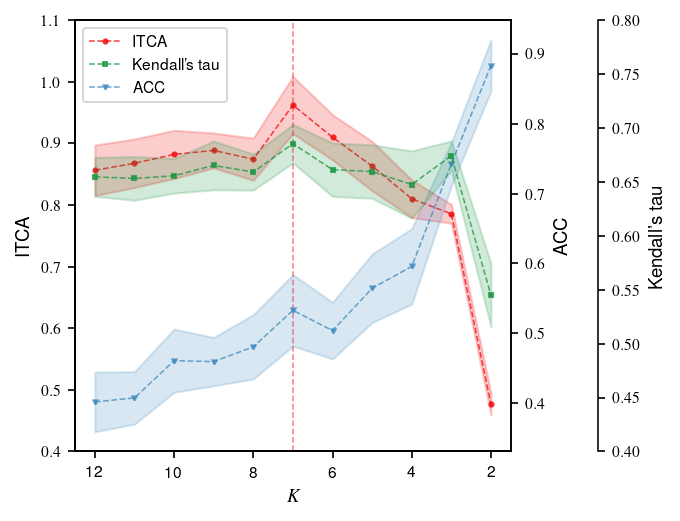

In [10]:
# third y-axis
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.2))
curve1, = host.plot(itca_mean, label="ITCA", color="#F20708", 
        marker="o", linestyle="--", alpha=0.75)
host.fill_between(np.arange(itca_mean.size), itca_mean - itca_std, 
                itca_mean + itca_std,
                alpha=0.2, color="#F20708")
curve2, = par2.plot(tau_mean, label="Kendall's tau", color="#1a9641",
        marker="s", linestyle="--", alpha=0.75)
par2.fill_between(np.arange(tau_mean.size), tau_mean - tau_std, 
                   tau_mean + tau_std,
                alpha=0.2, color="#1a9641")
curve3, = par1.plot(acc_mean, label="ACC", color="#3C8ABE",
        marker="v", linestyle="--", alpha=0.75)
par1.fill_between(np.arange(acc_mean.size), acc_mean - acc_std * factor, acc_mean + acc_std * factor,
                alpha=0.2, color="#3C8ABE")
host.axvline(x=ind_max, linestyle="--", color="#F20708", alpha=0.5)

host.set_ylabel("ITCA")
par2.set_ylabel("Kendall's tau")
par1.set_ylabel("ACC")
curves = [curve1, curve2, curve3]
host.legend(curves, [curve.get_label() for curve in curves], loc="upper left")
host.set_xticks([0, 2, 4, 6, 8, 10])
host.set_xticklabels([12, 10, 8, 6, 4, 2])
host.set_xlabel("$K$")
host.set_ylim([0.4, 1.1])
par2.set_ylim([0.4, 0.8])
fig.set_size_inches(4.5, 3.5)
plt.tight_layout()
plt.savefig("survival_prediction_cv_3yaxis_adjust_std.png",dpi=600)

## Table 7: Performance of survival prediction algorithms on the GBM dataset.

In [4]:
def print_table_row(res, name, factor=1 / np.sqrt(5)):
    tau_l = res["tau"]
    itca_l = [itca for itca in res["ITCA"]]
    cor = []
    pvals = []
    for tau in tau_l:
        cor.append(tau[0])
        pvals.append(tau[1])
    print("%s& $%.4f \pm %.4f$ & $%.4f \pm %.4f$ &%.2e" % (name, 
            np.mean(itca_l), np.std(itca_l) * factor, 
            np.mean(cor), np.std(cor) * factor, np.mean(pvals)))

In [84]:
# greedy search of LR model
# Run this code by uncomment the below line
# lr_path = greedy_search_cv(X, Y_arr, outpath="survival_checkpoint_lr.pkl", seed=2021, layers=[], activation='sigmoid')

=========2021-07-25 23:29:23=============
Start search....
=========2021-07-25 23:33:40=============
Round=1||Write in survival_checkpoint_lr.pkl
=========2021-07-25 23:33:40=============
Start search....
=========2021-07-25 23:37:33=============
Round=2||Write in survival_checkpoint_lr.pkl
=========2021-07-25 23:37:33=============
Start search....
=========2021-07-25 23:41:08=============
Round=3||Write in survival_checkpoint_lr.pkl
=========2021-07-25 23:41:08=============
Start search....
=========2021-07-25 23:44:18=============
Round=4||Write in survival_checkpoint_lr.pkl
=========2021-07-25 23:44:18=============
Start search....
=========2021-07-25 23:47:04=============
Round=5||Write in survival_checkpoint_lr.pkl
=========2021-07-25 23:47:04=============
Start search....
=========2021-07-25 23:49:26=============
Round=6||Write in survival_checkpoint_lr.pkl
=========2021-07-25 23:49:26=============
Start search....
=========2021-07-25 23:51:25=============
Round=7||Write in survi

In [21]:
file = open("survival_checkpoint_lr.pkl", 'rb')
lr_path = pickle.load(file) 
ind_max = np.argmax([np.mean(itca_l) for itca_l in lr_path["ITCA"]])
best_mapping = bidict(lr_path["mapping"][ind_max])

In [24]:
# LR model
lr_model1 = Net(36, len(mapping0.inverse), [], activation="sigmoid")
lr_model2 = Net(36, len(best_mapping.inverse), [], activation="sigmoid")

res_lr1 = eval_model_cv(X, Y_arr, mapping0, seed=2021, layers=[], 
                        activation="sigmoid",
                       opt_params={"lr": 0.0001, "momentum": 0.9,
                          "weight_decay": 0})
res_lr2 = eval_model_cv(X, Y_arr, best_mapping, seed=2021, layers=[], 
                        activation="sigmoid",
                       opt_params={"lr": 0.0001, "momentum": 0.9,
                          "weight_decay": 0})

In [34]:
#================================ Fit cox model ====================================
gbm_df_event = pd.concat([gbm_df_full, Y], axis=1)
# train model
cph = CoxPHFitter(penalizer=0.1)
my_df = gbm_df_event
my_df = gbm_df_event.drop(columns='IDH1 Mutation_R132G')
# Have to drop those variable to make the cox converge to a feasible solution
y_df = my_df.drop(columns=['TMZ Chemo', ' Alkylating Chemo', 'Alkylating Chemo',
    'Alkylating Chemoradiation'])
warnings.filterwarnings('ignore')
cph_tau = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in skf.split(X, Y_arr[:, 0]):
    train_df = my_df.iloc[train_index]
    test_df = my_df.iloc[test_index]
    censored_idx = test_df["Overall Survival Status"] == 0
    train_df = pd.concat([train_df, test_df[censored_idx]], axis=0)
    test_df = test_df[~censored_idx]
    try:
        cph.fit(train_df, duration_col="Overall Survival (Months)", 
           event_col="Overall Survival Status", step_size=0.1)
    except:
        print("Warning: convergence error occurs!")
    risk_score = cph.predict_partial_hazard(test_df)
    cph_tau.append(kendalltau(test_df["Overall Survival (Months)"], 
           -cph.predict_partial_hazard(test_df))) 

In [43]:
cox_tau = list(map(lambda x: x[0], cph_tau))
cox_pvals = list(map(lambda x: x[1], cph_tau))

In [ ]:
print_table_row(res1, "NN (no combination)")
print_table_row(res_lr1, "LR (no combination)")
print_table_row(res2, "NN (ITCA-guided)")
print_table_row(res_lr2, "LR (ITCA-guided)")
print("Cox regression (risk scores), {:.4f} ({:.4f}) & {})".format(np.mean(cox_tau), 
                                                                               np.std(cox_tau),
                                                                               np.mean(cox_pvals),                                                                        
                                                                              ))